In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform

In [2]:
data_path = "./data/data_with_human_TE_cellline_all_plain.csv"
df = pd.read_csv(data_path, delimiter="\t")
df.head()

,SYMBOL,transcript_id,gene_id,tx_size,utr5_size,cds_size,utr3_size,tx_sequence,bio_source_108T,bio_source_12T,...,struct_max_stem_len_UTR5,struct_max_loop_len_UTR5,struct_min_dG_CDS,struct_n_hairpins_CDS,struct_n_bifurc_CDS,struct_n_bulges_CDS,struct_start_stem_CDS,struct_max_stem_len_CDS,struct_max_loop_len_CDS,fold
0,SAMD11,ENST00000342066.8,ENSG00000187634.12,2557,90,2046,421,GCAGAGCCCAGCAGATCCCTGCGGCGTTCGCGAGGGTGGGACGGGA...,-3.644472,0.986720,...,10.0,5.0,-13.9,2.0,1.0,0.0,9.0,4.0,4.0,4
1,NOC2L,ENST00000327044.7,ENSG00000188976.11,2757,16,2250,491,GCTTCGGGTTGGTGTCATGGCAGCTGCGGGGAGCCGCAAGAGGCGC...,1.060190,0.701399,...,10.0,6.0,-24.5,1.0,0.0,0.0,21.0,10.0,6.0,8
2,KLHL17,ENST00000338591.8,ENSG00000187961.14,2567,110,1929,528,GGGAGTGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCTCC...,-1.198005,-1.178952,...,10.0,4.0,-23.0,1.0,1.0,1.0,3.0,9.0,5.0,9
3,HES4,ENST00000304952.11,ENSG00000188290.11,885,124,666,95,GCGGGCCTGGAGCCGGGATCCGCCCTAGGGGCTCGGATCGCCGCGC...,-1.107400,0.158079,...,16.0,3.0,-24.8,1.0,0.0,0.0,3.0,11.0,3.0,7
4,ISG15,ENST00000649529.1,ENSG00000187608.10,637,77,498,62,GGCGGCTGAGAGGCAGCGAACTCATCTTTGCCAGTACAGGAGCTTG...,0.631561,2.013887,...,8.0,5.0,-28.6,1.0,0.0,2.0,2.0,13.0,5.0,2


In [3]:
#number of unique cell lines -- number of columns that have "bio_source" in the name

print("Number of columns: ", len(df.columns))
print("Number of rows: ", len(df))

na_rows = df[df.isna().any(axis=1)]
print("Number of rows that have NA: ", len(na_rows))

bio_source_cols = [col for col in df.columns if 'bio_source' in col]
print(f"Number of unique human cell lines: {len(bio_source_cols)}")

Number of columns:  102
Number of rows:  11153
Number of rows that have NA:  354
Number of unique human cell lines: 78


In [4]:
#fill in the null values
df = df.dropna()
na_rows = df[df.isna().any(axis=1)]
print("Number of rows that have NA: ", len(na_rows))
print("Number of rows: ", len(df))
df.head()


Number of rows that have NA:  0
Number of rows:  10799


,SYMBOL,transcript_id,gene_id,tx_size,utr5_size,cds_size,utr3_size,tx_sequence,bio_source_108T,bio_source_12T,...,struct_max_stem_len_UTR5,struct_max_loop_len_UTR5,struct_min_dG_CDS,struct_n_hairpins_CDS,struct_n_bifurc_CDS,struct_n_bulges_CDS,struct_start_stem_CDS,struct_max_stem_len_CDS,struct_max_loop_len_CDS,fold
0,SAMD11,ENST00000342066.8,ENSG00000187634.12,2557,90,2046,421,GCAGAGCCCAGCAGATCCCTGCGGCGTTCGCGAGGGTGGGACGGGA...,-3.644472,0.986720,...,10.0,5.0,-13.9,2.0,1.0,0.0,9.0,4.0,4.0,4
1,NOC2L,ENST00000327044.7,ENSG00000188976.11,2757,16,2250,491,GCTTCGGGTTGGTGTCATGGCAGCTGCGGGGAGCCGCAAGAGGCGC...,1.060190,0.701399,...,10.0,6.0,-24.5,1.0,0.0,0.0,21.0,10.0,6.0,8
2,KLHL17,ENST00000338591.8,ENSG00000187961.14,2567,110,1929,528,GGGAGTGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCTCC...,-1.198005,-1.178952,...,10.0,4.0,-23.0,1.0,1.0,1.0,3.0,9.0,5.0,9
3,HES4,ENST00000304952.11,ENSG00000188290.11,885,124,666,95,GCGGGCCTGGAGCCGGGATCCGCCCTAGGGGCTCGGATCGCCGCGC...,-1.107400,0.158079,...,16.0,3.0,-24.8,1.0,0.0,0.0,3.0,11.0,3.0,7
4,ISG15,ENST00000649529.1,ENSG00000187608.10,637,77,498,62,GGCGGCTGAGAGGCAGCGAACTCATCTTTGCCAGTACAGGAGCTTG...,0.631561,2.013887,...,8.0,5.0,-28.6,1.0,0.0,2.0,2.0,13.0,5.0,2


In [ ]:
bio_source_cols = [col for col in df.columns if 'bio_source' in col]
bio_source_df = df[bio_source_cols]
bio_source_df.columns = bio_source_df.columns.str.replace('bio_source_', '')

In [17]:
spearman_corr = bio_source_df.corr(method='spearman')
print("Dimensions of spearman correlation matrix: ", spearman_corr.shape)

Dimensions of spearman correlation matrix:  (78, 78)


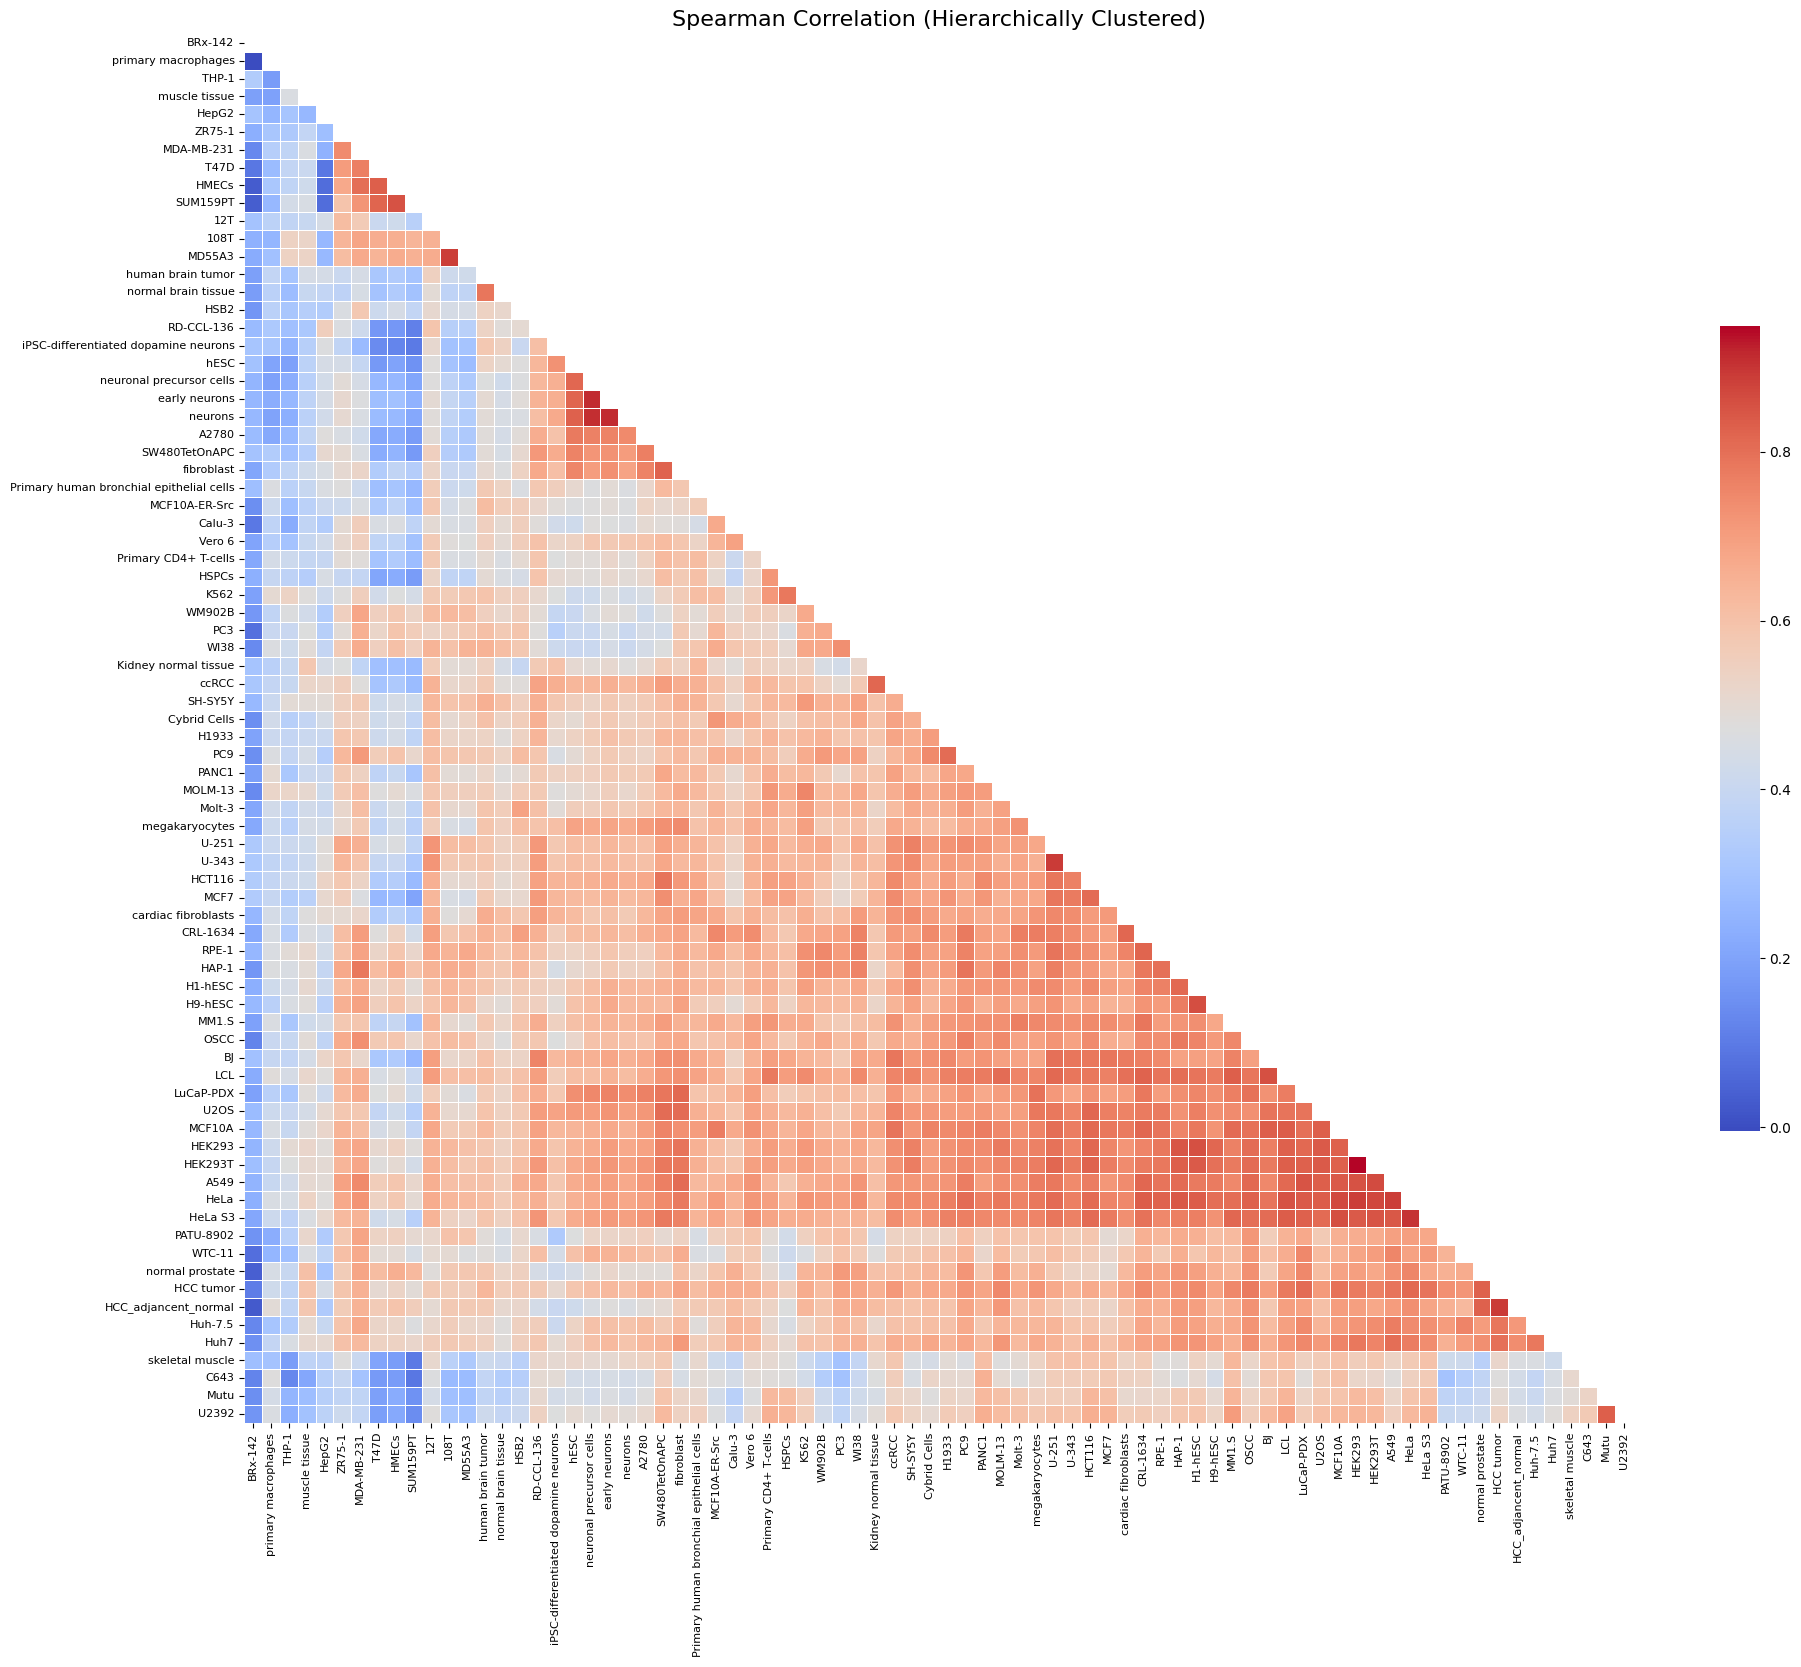

In [20]:
distance_matrix = 1 - spearman_corr
condensed_dist = squareform(distance_matrix.values)
linkage_matrix = linkage(condensed_dist, method='average')

ordered_indices = leaves_list(linkage_matrix)
ordered_corr = spearman_corr.iloc[ordered_indices, ordered_indices]

mask = np.triu(np.ones_like(ordered_corr, dtype=bool))

plt.figure(figsize=(20, 18))
sns.heatmap(
    ordered_corr, 
    mask=mask, 
    cmap='coolwarm', 
    annot=False, 
    fmt=".2f",
    linewidths=0.5, 
    square=True, 
    cbar_kws={"shrink": 0.5}
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Spearman Correlation (Hierarchically Clustered)", fontsize=16)
plt.tight_layout()
plt.savefig('spearman_correlation_heatmap.png')
plt.show()
